<a href="https://colab.research.google.com/github/saliSoul/CalculatorApp/blob/main/05.%20Ensemble%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Tutorial #04

# Ensemble Learning

by [David Luke Elliott](https://www.lancaster.ac.uk/psychology/about-us/people/david-elliott)
/ [GitHub](https://github.com/Eldave93)

Ensemble methods aim to improve generalizability of an algorithm by combining the predictions of several estimators<sup>1,2</sup>. To acheive this there are two general methods, averaging and boosting.

**Notes**
- watch [this video] for more information on some methods

---
1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.
2. https://scikit-learn.org/stable/modules/ensemble.html
[this video]: https://youtu.be/wPqtzj5VZus

# Environment Set-up

First lets install the packages we need

In [1]:
!pip install h5py tables kaggle mne
!pip install --upgrade imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 93.9 MB/s eta 0:00:00


In [2]:
import os                         # for file locations
import matplotlib.pyplot as plt   # for plotting
import numpy as np                # arrays
import pickle                     # saving python objects
import pandas as pd               # dataframes
import tables

# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

We are going to start using a different dataset from the Epileptologie one we have been using so far. This is because Epileptologie only has 1 channel, is quite small, and we already were getting good results with it without the need for ensemble learning.

We are going to use the data which was origionally a kaggle competition in 2014<sup>1</sup> (see the first notebook for more information).

---
1. https://www.kaggle.com/c/seizure-detection

In [3]:
import gdown
FILE_PATH = 'UPennMayo_features.hdf5'

if not os.path.exists(FILE_PATH):
    gdown.download('https://drive.google.com/uc?id=1-0Y0eKW9hIeOdKlYbi9UAojERKbQzi5d',
                './'+FILE_PATH, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-0Y0eKW9hIeOdKlYbi9UAojERKbQzi5d
To: /content/UPennMayo_features.hdf5
100%|██████████| 47.9M/47.9M [00:00<00:00, 157MB/s]


## Load Data

First lets start by getting our workspace ready and then loading in the data. I have saved the data in a hdf5 file.

**TODO**
- Write a brief summary of hdf5 files and how I use them.

In [4]:
# load features dataframe
h5file = tables.open_file(FILE_PATH, mode="r+")
h5file

File(filename=UPennMayo_features.hdf5, title=np.str_('Upenn Features'), mode='r+', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) np.str_('Upenn Features')
/Patient_2 (Group) np.str_('Participant Data')
/Patient_2/Data_x (EArray(np.int64(7035), np.int64(848))) 'Feature Array'
  atom := Float64Atom(shape=(), dflt=np.float64(0.0))
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (np.int64(9), np.int64(848))
/Patient_2/Data_x_Feat_Names (Array(np.int64(848),)) np.str_('Names of Each Feature')
  atom := StringAtom(itemsize=29, shape=(), dflt=np.bytes_(b''))
  maindim := 0
  flavor := np.str_('numpy')
  byteorder := 'irrelevant'
  chunkshape := None
/Patient_2/Data_y (EArray(np.int64(7035), np.int64(1))) 'Events Array'
  atom := Int64Atom(shape=(), dflt=np.int64(0))
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (np.int64(8192), np.int64(1))

If we look in this hdf5 file we see there is only data from 1 human patient out of the possible 8. Thats because for this tutorial, we'll use patient 2 as an example to increase training speed compared to the full set.

**NOTE**
- if you want the full set of human data then I made a version called *UPennMayo_all_features.hdf5*

In [7]:
import h5py
with h5py.File(FILE_PATH, 'r') as f:
  key_list = list(f.keys())
display(key_list)

BlockingIOError: [Errno 11] Unable to synchronously open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

If you want more specific detail on the features than below then I recommend you look at the tutorial associated with the feature extraction.

The dataset has multipule channels (different for each participant) and has previously been segmented into multipule datasets each lasting 1 second. Each dataset is associated with a class and has features extracted from it. These briefly are:

**Welch**

The Welch method is a spectral density estimation method that calculates a periodogram for windowed sections of data using a Fourier Transform. Overlapping segments are windowed with a discrete Fourier tranform applied to calculate the periodogram which is then squared and averaged to get a power measure.
- *power_delta*: Average power between 0.1hz and 4hz
- *power_theta*: Average power between 4hz and 8hz
- *power_alpha*: Average power between 8hz and 12hz
- *power_beta*: Average power between 12hz and 30hz
- *power_gamma*: Average power between 30hz and 70hz

**Discrete Wavelet Transform**

Several oscillatory kernel-based wavelets are stretched and moved to different positions in time across a signal, dividing the data into different frequency components which are each analysed in respect to their scale.
- *LSWT*: The log-sum energy of the subband coefficients
- *mean*: Average power of the wavelet coefficients in each sub-band
- *mean_abs*: Mean of the absolute values of the coefficients in each sub-band
- *std*: Standard deviation of the coefficients in each sub-band
- *Ratio*: Ratio of the absolute mean values of adjacent sub-bands

**Correlation and Eigenvalues<sup>2,3</sup>**

The log10 of frequency magnitudes, calculated using a Fast Fourier Transform, was gained for each EEG channel in each dataset. The FFT output was normalised across frequency (1-47Hz) and the correlation coefficients matrix calculated. Eigenvalues are then also calculated on the correlation matrix. Both eigenvalues and correlation coefficients were gained in the time domain as well as the Frequency domain.

---
1. https://www.kaggle.com/c/seizure-detection
2. https://github.com/MichaelHills/seizure-detection
3. K Schindler, H Leung, CE Elger, K Lehnertz (2007) Assessing seizure dynamics by analysing the correlation structure of multichannel intracranial EEG. Brain 130(Pt1):65-77

In [8]:
data_x = h5file.get_node('/Patient_2/Data_x')
data_y = h5file.get_node('/Patient_2/Data_y')
data_x_labels = h5file.get_node('/Patient_2/Data_x_Feat_Names')

part_feature_df = pd.DataFrame(data_x[:], columns = data_x_labels[:].astype(str))
part_feature_df['class'] = data_y[:]
part_feature_df = part_feature_df.set_index('class')
part_feature_df.head()

,LMacro_01|2_4Hz,LMacro_01|4_8Hz,LMacro_01|8_12Hz,LMacro_01|12_30Hz,LMacro_01|30_70Hz,LMacro_01|Ratio_3_12/2_30Hz,LMacro_01|D6_mean,LMacro_01|D5_mean,LMacro_01|D4_mean,LMacro_01|D3_mean,...,RMacro_04_RMacro_05|time_corr,RMacro_04_RMacro_06|time_corr,RMacro_04_RMacro_07|time_corr,RMacro_04_RMacro_08|time_corr,RMacro_05_RMacro_06|time_corr,RMacro_05_RMacro_07|time_corr,RMacro_05_RMacro_08|time_corr,RMacro_06_RMacro_07|time_corr,RMacro_06_RMacro_08|time_corr,RMacro_07_RMacro_08|time_corr
class,,,,,,,,,,,,,,,,,,,,,
1,227.771604,121.729376,104.748192,12.558394,0.647189,0.236310,-1.464481,-0.824742,0.013091,0.079837,...,0.273753,0.363735,0.389202,0.297462,0.789810,0.652605,0.519944,0.953851,0.796902,0.888274
1,162.957202,77.334727,39.298664,159.289935,17.511810,0.521757,-0.524147,-2.195927,0.170249,0.077665,...,0.402350,0.379938,0.046323,-0.029894,0.765875,0.426919,0.379509,0.808733,0.732159,0.911896
1,7.328949,42.812358,74.461760,98.214038,8.702826,0.631694,4.117210,-0.597011,-0.399529,0.090689,...,-0.020415,-0.103571,-0.071538,-0.048586,0.807652,0.638780,0.563594,0.936139,0.864730,0.954777
1,213.279844,85.966538,48.585487,241.390643,19.657826,1.773919,1.079959,0.292291,0.022378,0.049902,...,-0.194032,-0.129580,0.018119,0.232352,0.842868,0.673148,0.445052,0.857085,0.559804,0.861035
1,44.163924,27.442250,42.136054,177.165579,15.002302,1.353723,-1.712907,1.431398,-0.246839,-0.003639,...,0.099375,0.115953,0.158055,0.105109,0.680998,0.362963,0.242693,0.834629,0.653866,0.911919


## Data Preparation

We'll just remove the data that was used for the test set (2) in the competition as quite frankly we don't know what they represent. This will leave just our known ictal data (1) and inter-ictal (0) data.

**Note**
- I noticed in a paper that they contacted the kaggle organisers for test labels:

    "*Dr Benjamin H. Brinkmann support from Mayo Systems Electrophysiology Lab for providing information on some unlabeled datasets*"
    
    so if you really want them then maybe this could be an option?

In [9]:
part_feature_df.index.value_counts()

,count
class,
2,3894
0,2990
1,151


In [10]:
reduced_features = part_feature_df.loc[[0,1]]
reduced_features.head()

,LMacro_01|2_4Hz,LMacro_01|4_8Hz,LMacro_01|8_12Hz,LMacro_01|12_30Hz,LMacro_01|30_70Hz,LMacro_01|Ratio_3_12/2_30Hz,LMacro_01|D6_mean,LMacro_01|D5_mean,LMacro_01|D4_mean,LMacro_01|D3_mean,...,RMacro_04_RMacro_05|time_corr,RMacro_04_RMacro_06|time_corr,RMacro_04_RMacro_07|time_corr,RMacro_04_RMacro_08|time_corr,RMacro_05_RMacro_06|time_corr,RMacro_05_RMacro_07|time_corr,RMacro_05_RMacro_08|time_corr,RMacro_06_RMacro_07|time_corr,RMacro_06_RMacro_08|time_corr,RMacro_07_RMacro_08|time_corr
class,,,,,,,,,,,,,,,,,,,,,
0,114.541010,26.387061,11.821119,1.357175,0.127231,0.080726,-0.128602,0.118216,-0.101168,-0.033279,...,-0.303116,-0.431413,-0.376480,-0.411506,0.544665,0.179166,0.469152,0.890269,0.827349,0.822477
0,27.574621,43.245174,18.910574,0.791160,0.113143,0.028620,-0.566416,-0.064466,-0.082230,0.007399,...,-0.427137,-0.388867,-0.327155,-0.370580,0.750489,0.593814,0.665086,0.956724,0.870345,0.912751
0,58.207500,18.142876,8.238157,1.537487,0.341276,0.179073,0.500630,-0.156088,0.016892,0.061672,...,0.121037,0.126031,0.092073,-0.025342,0.779517,0.483535,0.452129,0.887166,0.724896,0.718923
0,142.960698,11.285728,13.005110,1.014406,0.283393,0.118613,-0.823890,0.296830,0.030066,-0.039112,...,0.119059,0.116303,0.282626,0.113695,0.737446,0.529281,0.288499,0.719412,0.648070,0.786587
0,221.105230,39.302649,28.439736,3.143172,0.317358,0.072439,0.119001,0.103982,-0.235290,-0.002702,...,-0.272180,0.054720,-0.089779,0.077794,0.721609,0.470620,0.344036,0.810304,0.774646,0.820247


In [11]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.1
RANDOM_STATE = 0

# turn to numpy array
data_x = reduced_features.values

# create condition(group) array
data_y = reduced_features.index.values

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(2543, 848) (283, 848) (315, 848)
(2543,) (283,) (315,)


# Averaging Methods
Averaging methods build several separate estimators and then, as their name suggets, average their predictions. By reducing the variance these tend to perform better than any single base estimator<sup>1</sup>.

---

1. https://scikit-learn.org/stable/modules/ensemble.html

## Bagging
A bagging classifier is an ensemble of base classifiers, each fit on random subsets of a dataset. Their predictions are then pooled or aggregated to form a final prediction. This reduces variance of an estimator and can be a simple way to reduce overfitting. They work best with complex models as opposed to boosting, which work best with weak models<sup>1</sup>.

Specifically, bagging is when sampling is produced with replacement<sup>2</sup>, and without replacement being called pasting<sup>3</sup>. Therefore both bagging and pasting allow training to be sampled several times across multipule predictors, with bagging only allowing several samples for the same predictor <sup>4</sup>.

We can do this with any classifier so lets start with a support vector machine.

**NOTE**
- If we wanted to use pasting we would just set *bootstrap=False*.

---

1. https://scikit-learn.org/stable/modules/ensemble.html
2. Breiman, L. (1996). Bagging predictors. Machine learning, 24(2), 123-140.
3. Breiman, L. (1999). Pasting small votes for classification in large databases and on-line. Machine learning, 36(1-2), 85-103.
4. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".

In [13]:
%%time

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

pipe_svc = Pipeline([('scl', StandardScaler()),
                     ('pca', PCA(n_components=0.8, random_state = RANDOM_STATE)),
                     ('clf', SVC(kernel='rbf', random_state=RANDOM_STATE))])

bag = BaggingClassifier(estimator=pipe_svc,
                        n_estimators=10,
                        max_samples=0.5,
                        max_features=0.5,
                        bootstrap=True,
                        bootstrap_features=True,
                        oob_score=True,
                        warm_start=False,
                        n_jobs=-1,
                        random_state=RANDOM_STATE)
bag.fit(X_train, y_train)

CPU times: user 1.71 s, sys: 65 ms, total: 1.77 s
Wall time: 6.31 s


BaggingClassifier(bootstrap_features=True,
                  estimator=Pipeline(steps=[('scl', StandardScaler()),
                                            ('pca',
                                             PCA(n_components=0.8,
                                                 random_state=0)),
                                            ('clf', SVC(random_state=0))]),
                  max_features=0.5, max_samples=0.5, n_jobs=-1, oob_score=True,
                  random_state=0)

As we can see performance is okay but recall is particularly poor. It is likely the model is not complex enough or each model in the ensemble is too similar to each add value (we'll look at solving this soon).

In [14]:
y_pred = bag.predict(X_val)

display(pd.DataFrame(classification_report(y_val, y_pred , output_dict =True)))

,0,1,accuracy,macro avg,weighted avg
precision,0.985294,0.818182,0.978799,0.901738,0.977618
recall,0.992593,0.692308,0.978799,0.842450,0.978799
f1-score,0.988930,0.750000,0.978799,0.869465,0.977954
support,270.000000,13.000000,0.978799,283.000000,283.000000


An additional way we can get a performance metric on a validation set is to ensure we use `oob_score = True`

With bagging by default only trains on a sample of the training data, leaving a set of training data sampled as out-of-bag (oob) instances. Since they are not seen during training, we can evalute on them without a separate validation using the oob_score.

This estimated that its likely to get an accuracy of about 0.99 on the test/validation set so its a pretty close to what we did get above.

In [15]:
bag.oob_score_

0.9897758552890287

Maybe we think that the problem with our previous model was that we didnt fully account for the imballances in the data. Then we could use a ballanced bagging classifier, but again this performs poorly.

In [17]:
from imblearn.ensemble import BalancedBaggingClassifier

bal_bag = BalancedBaggingClassifier(estimator=pipe_svc,
                                n_estimators=10,
                                max_samples=0.5,
                                max_features=0.5,
                                bootstrap=True,
                                bootstrap_features=True,
                                oob_score=True,
                                warm_start=False,
                                sampling_strategy ='majority',
                                replacement=True,
                                n_jobs=-1,
                                random_state=RANDOM_STATE)
bal_bag.fit(X_train, y_train)

y_pred = bal_bag.predict(X_val)

display(pd.DataFrame(classification_report(y_val, y_pred , output_dict =True)))

,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.590909,0.968198,0.795455,0.981208
recall,0.966667,1.000000,0.968198,0.983333,0.968198
f1-score,0.983051,0.742857,0.968198,0.862954,0.972017
support,270.000000,13.000000,0.968198,283.000000,283.000000


So instead lets look at a more complex model that aims to ensure each classifier in the ensemble makes different errors.

## Random Forests

Random forests are essentally bagged tree classifier. However, rather than using the bagging method above we can use one of the inbuilt methods Sklearn has specifically designed for fitting an ensemble of trees. A random forest is just a fancier version of bagging where multiple decision trees are averaged together to build a robust model that is less susceptible to overfitting.

The random forest algorithm can be summarized in four steps<sup>1</sup>:

> 1. *Draw a random bootstrap sample of size n (randomly choose n samples from the training set with replacement).*
> 2. *Grow a decision tree from the bootstrap sample. At each node:*
>
>    *a. Randomly select d features without replacement.*
>    
>    *b. Split the node using the feature that provides the best split according to the objective function, for instance, maximizing the information gain.*
>
>3. *Repeat the steps 1-2 k times.*
>4. *Aggregate the prediction by each tree to assign the class label by majority vote.*

Instead of using majority vote, as was done in the origional publication<sup>2</sup>, in Sklearn the RandomForestClassifier averages the probabilistic prediction.

**NOTES**
- We cannot use the graphviz on the whole forest as we did for the trees in the supervised learning notebook, as each tree is built differently.

---
1. Raschka2017
2. L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001

In [18]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=1000,
                                max_features = 'sqrt',
                                class_weight = 'balanced',
                                random_state=RANDOM_STATE,
                                n_jobs=-1)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_val)

display(pd.DataFrame(classification_report(y_val, y_pred , output_dict = True)))

,0,1,accuracy,macro avg,weighted avg
precision,0.996296,0.923077,0.992933,0.959687,0.992933
recall,0.996296,0.923077,0.992933,0.959687,0.992933
f1-score,0.996296,0.923077,0.992933,0.959687,0.992933
support,270.000000,13.000000,0.992933,283.000000,283.000000


Lets look at how a descion boundary created by a bagged tree could generalise better than a single tree (as we did in the supervised learning notebook)

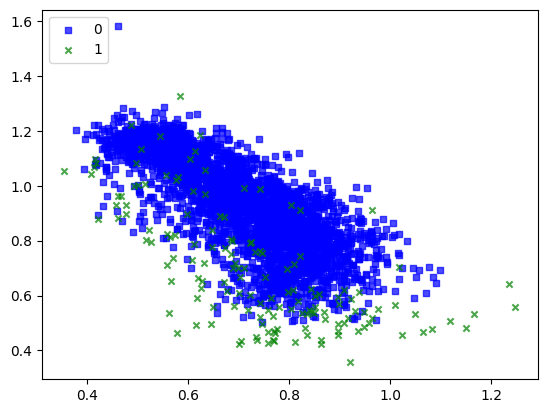

In [19]:
from mlxtend.plotting import category_scatter

x_axis_label = 'LMacro_03|D4_ratio'
y_axis_label =  'LMacro_03|D2_ratio'

reduced_features_reset = reduced_features.reset_index()

fig = category_scatter(x=x_axis_label, y=y_axis_label, label_col='class',
                       data=reduced_features_reset, legend_loc='upper left')

feature_list = list(reduced_features.columns)

two_features_data = reduced_features.iloc[:,[feature_list.index(x_axis_label),feature_list.index(y_axis_label)]]

Tree


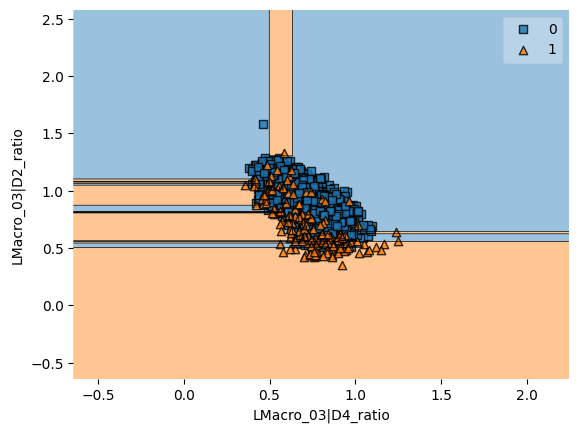

Forest


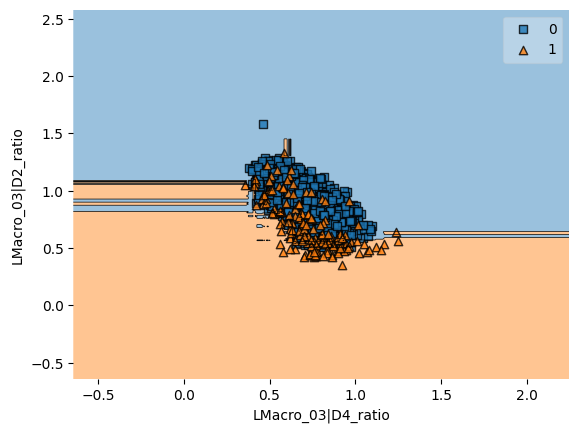

In [20]:
from mlxtend.plotting import plot_decision_regions
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

tree = DecisionTreeClassifier(criterion='gini',
                              class_weight = 'balanced',
                              random_state=RANDOM_STATE)

tree_dict = {'Tree':tree, 'Forest':forest}

for classifier_name in tree_dict:

  tree_dict[classifier_name].fit(two_features_data.values, reduced_features_reset['class'].values)

  plot_decision_regions(two_features_data.values,
                        reduced_features_reset['class'].values,
                        clf = tree_dict[classifier_name])

  plt.xlabel(x_axis_label)
  plt.ylabel(y_axis_label)

  print(color.BOLD+color.UNDERLINE+classifier_name+color.END)
  plt.show()

As well as Random forests, Extremely randomized trees<sup>1</sup> can also be used. These work similarly to Random forests except...

"*...instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias*"<sup>2</sup>.

In this case it appears we are better served by the random forest.

---
1. Geurts, P., Ernst, D., & Wehenkel, L. (2006). Extremely randomized trees. Machine learning, 63(1), 3-42.
2. https://scikit-learn.org/stable/modules/ensemble.html

In [21]:
from sklearn.ensemble import ExtraTreesClassifier

# create a forest classifier
ETSC = ExtraTreesClassifier(criterion='gini',
                            n_estimators=1000,
                            max_features = 'sqrt',
                            class_weight = 'balanced',
                            random_state=RANDOM_STATE,
                            n_jobs=-1)

ETSC.fit(X_train, y_train)

y_pred = ETSC.predict(X_val)

display(pd.DataFrame(classification_report(y_val, y_pred, output_dict = True)))

,0,1,accuracy,macro avg,weighted avg
precision,0.996296,0.923077,0.992933,0.959687,0.992933
recall,0.996296,0.923077,0.992933,0.959687,0.992933
f1-score,0.996296,0.923077,0.992933,0.959687,0.992933
support,270.000000,13.000000,0.992933,283.000000,283.000000


It is also worth noting we have been dealing with the class imballance found in this data by using `class_weight = 'balanced'` to assign more importance to getting ictal data predictions correct. We can however also undersample using a ballanced random forest. Generally what performs better depends on the amount of data you are training on. If small then class wight will be better (as seen below), but if you have very large datasets, then undersampling will likely work better.

In [22]:
from imblearn.ensemble import BalancedRandomForestClassifier

bal_forest = BalancedRandomForestClassifier(criterion='gini',
                                            n_estimators=1000,
                                            max_features = 'sqrt',
                                            random_state=RANDOM_STATE,
                                            n_jobs=-1
                                            )
bal_forest.fit(X_train, y_train)

y_pred = bal_forest.predict(X_val)

display(pd.DataFrame(classification_report(y_val, y_pred , output_dict = True)))

,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.565217,0.964664,0.782609,0.980028
recall,0.962963,1.000000,0.964664,0.981481,0.964664
f1-score,0.981132,0.722222,0.964664,0.851677,0.969239
support,270.000000,13.000000,0.964664,283.000000,283.000000


In [23]:
# prompt: add other performing new ml methods

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb

# ## Boosting Methods
# Boosting methods combine several weak learners into a strong learner. Each subsequent estimator is trained on the instances that the previous estimators misclassified, attempting to correct its mistakes<sup>1</sup>.
#
# ---
# 1. https://scikit-learn.org/stable/modules/ensemble.html

# ### AdaBoost (Adaptive Boosting)
# AdaBoost is one of the earliest boosting algorithms. It works by weighting misclassified samples more heavily in subsequent iterations.

ada = AdaBoostClassifier(n_estimators=100, random_state=RANDOM_STATE)
ada.fit(X_train, y_train)

y_pred = ada.predict(X_val)
display(pd.DataFrame(classification_report(y_val, y_pred , output_dict = True)))

# ### Gradient Boosting
# Gradient Boosting builds additive models in a forward stage-wise fashion, allowing for optimization of arbitrary differentiable loss functions.

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_val)
display(pd.DataFrame(classification_report(y_val, y_pred , output_dict = True)))

# ### XGBoost (Extreme Gradient Boosting)
# XGBoost is a highly optimized gradient boosting implementation. It is known for its speed and performance.

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_val)
display(pd.DataFrame(classification_report(y_val, y_pred , output_dict = True)))

# ### LightGBM (Light Gradient Boosting Machine)
# LightGBM is another gradient boosting framework that uses tree-based learning algorithms. It is designed to be distributed and efficient.

lgb_clf = lgb.LGBMClassifier(objective='binary', n_estimators=100, random_state=RANDOM_STATE)
lgb_clf.fit(X_train, y_train)

y_pred = lgb_clf.predict(X_val)
display(pd.DataFrame(classification_report(y_val, y_pred , output_dict = True)))


,0,1,accuracy,macro avg,weighted avg
precision,0.996296,0.923077,0.992933,0.959687,0.992933
recall,0.996296,0.923077,0.992933,0.959687,0.992933
f1-score,0.996296,0.923077,0.992933,0.959687,0.992933
support,270.000000,13.000000,0.992933,283.000000,283.000000


,0,1,accuracy,macro avg,weighted avg
precision,0.996269,0.800000,0.985866,0.898134,0.987253
recall,0.988889,0.923077,0.985866,0.955983,0.985866
f1-score,0.992565,0.857143,0.985866,0.924854,0.986344
support,270.000000,13.000000,0.985866,283.000000,283.000000


,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.866667,0.992933,0.933333,0.993875
recall,0.992593,1.000000,0.992933,0.996296,0.992933
f1-score,0.996283,0.928571,0.992933,0.962427,0.993172
support,270.000000,13.000000,0.992933,283.000000,283.000000


[LightGBM] [Info] Number of positive: 131, number of negative: 2412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216240
[LightGBM] [Info] Number of data points in the train set: 2543, number of used features: 848
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.051514 -> initscore=-2.913014
[LightGBM] [Info] Start training from score -2.913014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

,0,1,accuracy,macro avg,weighted avg
precision,0.996283,0.857143,0.989399,0.926713,0.989891
recall,0.992593,0.923077,0.989399,0.957835,0.989399
f1-score,0.994434,0.888889,0.989399,0.941662,0.989586
support,270.000000,13.000000,0.989399,283.000000,283.000000


## Majority Voting

As we have seen from bagging, a group of classifiers don't have to all be descision trees. Indeed Scikitlearn has a VotingClassifier where multipule classification pipelines can be combined to create an even better classifier that aggregates predictions. This aggregation can be done by simply selecting the class label that has been predicted by the majority of the classifiers (more than 50% of votes) for 'hard voting'. Majority vote refers to binary class decisions but can be generalized to a multi-class setting using 'plurality voting'. Particular classifiers return the probability of a predicted class label via the predict_proba method and this can be used for 'soft voting' instead of class labels<sup>1</sup>.

Ensemble methods work best when the predictors are as independent as possible, so one way of achiving this is to get diverse classifiers. This increases the chance they each make different types of errors which in combination will improve the overall accuracy<sup>2</sup>.

As can be seen below the soft majority voter has better scores than the hard voting method and better than most other methods individually when all are on their default settings. Soft voting often achives a higher performance than hard voting because highly confident votes are given more weight<sup>2</sup>.

**NOTE**
- with some hyper-parameter optimisation its likely we could increase the performance of the soft-majority vote.

---
1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017
2. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".

In [ ]:
# prompt: add majority vote of the previous ml models too :%%time
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import VotingClassifier
# from sklearn.pipeline import Pipeline
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import cross_val_score
# from imblearn.under_sampling import NeighbourhoodCleaningRule
# from sklearn.decomposition import PCA
# import timeit
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, make_scorer
# clf1 = Pipeline([('scl', StandardScaler()),
#                  ('clf', SVC(kernel='rbf',
#                              gamma='auto',
#                              random_state=RANDOM_STATE,
#                              probability = True))])
# clf2 = Pipeline([('scl', StandardScaler()),
#                  ('clf', LogisticRegression(solver='liblinear',
#                                             random_state=RANDOM_STATE))
# ])
# clf3 = DecisionTreeClassifier(random_state=RANDOM_STATE)
# clf_labels = ['SVM', # Support Vector Machine
#               'LR', # LogisticRegression
#               'DT'] # Decision Tree
# # Majority Rule Voting
# hard_mv_clf = VotingClassifier(estimators=[(clf_labels[0],clf1),
#                                            (clf_labels[1],clf2),
#                                            (clf_labels[2],clf3)],
#                                voting='hard')
# soft_mv_clf = VotingClassifier(estimators=[(clf_labels[0],clf1),
#                                            (clf_labels[1],clf2),
#                                            (clf_labels[2],clf3)],
#                                voting='soft')
# clf_labels += ['Hard Majority Voting', 'Soft Majority Voting']
# all_clf = [clf1, clf2, clf3, hard_mv_clf, soft_mv_clf]
# print(color.BOLD+color.UNDERLINE+'Validation Scores\n'+color.END)
# for clf, label in zip(all_clf, clf_labels):

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

for clf, label in zip(all_clf, clf_labels):
    # scoring = make_scorer(accuracy_score)
    # scores = cross_val_score(estimator=clf,
                            #  X=X_train,
                            #  y=y_train,
                            #  cv=StratifiedKFold(n_splits=10,
                            #                     shuffle=True,
                            #                     random_state=RANDOM_STATE),
                            #  scoring=scoring,
                            #  n_jobs=-1)
    # print("Accuracy: %0.4f (+/- %0.2f) [%s]"
    #       % (scores.mean(), scores.std(), label))

    start_time = timeit.default_timer()

    clf.fit(X_train, y_train)

    elapsed = timeit.default_timer() - start_time

    y_pred = clf.predict(X_val)

    display(pd.DataFrame(classification_report(y_val, y_pred , output_dict = True)))

    print(f'Time to train and validate: {elapsed:0.2f}s')


In [24]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import NeighbourhoodCleaningRule
from sklearn.decomposition import PCA
import timeit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, make_scorer

clf1 = Pipeline([('scl', StandardScaler()),
                 ('clf', SVC(kernel='rbf',
                             gamma='auto',
                             random_state=RANDOM_STATE,
                             probability = True))])

clf2 = Pipeline([('scl', StandardScaler()),
                 ('clf', LogisticRegression(solver='liblinear',
                                            random_state=RANDOM_STATE))
])

clf3 = DecisionTreeClassifier(random_state=RANDOM_STATE)

clf_labels = ['SVM', # Support Vector Machine
              'LR', # LogisticRegression
              'DT'] # Decision Tree

# Majority Rule Voting
hard_mv_clf = VotingClassifier(estimators=[(clf_labels[0],clf1),
                                           (clf_labels[1],clf2),
                                           (clf_labels[2],clf3)],
                               voting='hard')

soft_mv_clf = VotingClassifier(estimators=[(clf_labels[0],clf1),
                                           (clf_labels[1],clf2),
                                           (clf_labels[2],clf3)],
                               voting='soft')

clf_labels += ['Hard Majority Voting', 'Soft Majority Voting']
all_clf = [clf1, clf2, clf3, hard_mv_clf, soft_mv_clf]

print(color.BOLD+color.UNDERLINE+'Validation Scores\n'+color.END)
for clf, label in zip(all_clf, clf_labels):
    start = timeit.default_timer() # TIME STUFF

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    scores = f1_score(y_val, y_pred)
    print(color.BOLD+label+color.END)
    print("Score: %0.3f"
          % scores)
    # TIME STUFF
    stop = timeit.default_timer()
    print("Run time:", np.round((stop-start)/60,2),"minutes")
    print()

Validation Scores

SVM
Score: 0.889
Run time: 0.06 minutes

LR
Score: 0.897
Run time: 0.03 minutes

DT
Score: 0.706
Run time: 0.05 minutes

Hard Majority Voting
Score: 0.889
Run time: 0.14 minutes

Soft Majority Voting
Score: 0.929
Run time: 0.13 minutes

CPU times: user 27.7 s, sys: 158 ms, total: 27.9 s
Wall time: 24.4 s


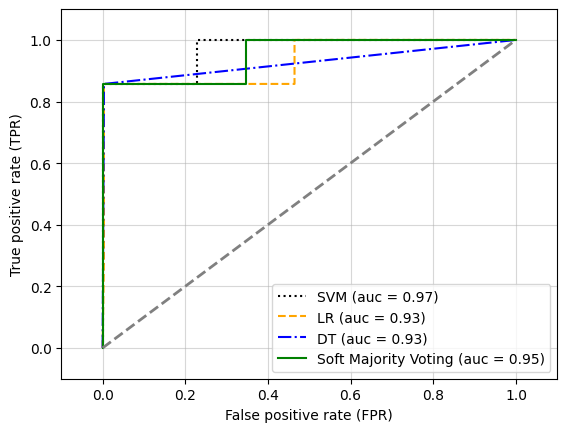

CPU times: user 16.9 s, sys: 118 ms, total: 17 s
Wall time: 14.7 s


In [25]:
%%time
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# remove the hard voting because doesnt have predict proba
del clf_labels[3], all_clf[3]

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                          y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

#plt.savefig(os.path.join(IMAGE_DIR, 'Pipeline_Rocs.png'), dpi=300)
plt.show()

# Boosting Methods

Boosting methods are typically weak estimators that are built sequentially with each estimator attempting to reduce the bias of the predecessor<sup>1</sup>. The weak learners often only have a slight performance advantage over random guessing, but by focusing on training samples that are hard to classify, the overall performance of the ensemble is improved<sup>2</sup>.

Compared to bagging models, boosting can lead to a decrease in bias and variance, but algorithms such as AdaBoost are also known for overfitting to the training data (high variance)<sup>2</sup>.

---
1. Geron2017
2. Python Machine Learning

## AdaBoost

For AdaBoost<sup>1</sup>, the first base classifier is trained to make predictions on the training set. Afterwards the weights of misclssified training instances are increased. A second classifier then is traind with these new weights and makes predictions. This is then repeated until all predictors are trained, wherein the ensemble makes predictions like bagging, except with weights depending on overall accuracy on the weighted training set <sup>2</sup>.

**NOTES**
- SVM's are generally not good predictors for AdaBoost due to being slow and unstable in this context<sup>2</sup>.
- Boosting in this way tends to be slower than bagging as each tree needs to be grown sequentially as they depend on each other rather than able to be grown in parallel. As such I reduced the number of estimators for this example.

---
1. Freund, Y., & Schapire, R. E. (1997). A decision-theoretic generalization of on-line learning and an application to boosting. Journal of computer and system sciences, 55(1), 119-139.
2. Geron2017

In [27]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='gini',
                              max_depth=1,
                              random_state=RANDOM_STATE)

ada = AdaBoostClassifier(estimator=tree,
                         n_estimators=100,
                         learning_rate=0.1,
                         random_state=RANDOM_STATE)

ada.fit(X_train, y_train)

y_pred = ada.predict(X_val)

display(pd.DataFrame(classification_report(y_val, y_pred , output_dict = True)))

,0,1,accuracy,macro avg,weighted avg
precision,0.996283,0.857143,0.989399,0.926713,0.989891
recall,0.992593,0.923077,0.989399,0.957835,0.989399
f1-score,0.994434,0.888889,0.989399,0.941662,0.989586
support,270.000000,13.000000,0.989399,283.000000,283.000000


CPU times: user 56.2 s, sys: 200 ms, total: 56.4 s
Wall time: 56.8 s


## Gradient Boosting
Gradient Boosting works similar to AdaBoost in that it sequentially adds predictors to correct predessessors in an ensemble. However instead of changing weights it fits a model to the residual errors<sup>1</sup>.

Lets run through a quick example given in Geron (2017)<sup>1</sup>.

---
1. Geron2017

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

tree_reg1 = DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE)
tree_reg1.fit(X_train, y_train)

y_train2 = y_train - tree_reg1.predict(X_train)
tree_reg2 = DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE)
tree_reg2.fit(X_train, y_train2)

y_train3 = y_train2 - tree_reg2.predict(X_train)
tree_reg3 = DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE)
tree_reg3.fit(X_train, y_train3)

y_pred = sum(tree.predict(X_val) for tree in (tree_reg1, tree_reg2, tree_reg3))

pd.DataFrame(classification_report(y_val, y_pred , output_dict =True))

,0,1,accuracy,macro avg,weighted avg
precision,0.996269,0.800000,0.985866,0.898134,0.987253
recall,0.988889,0.923077,0.985866,0.955983,0.985866
f1-score,0.992565,0.857143,0.985866,0.924854,0.986344
support,270.000000,13.000000,0.985866,283.000000,283.000000


A simpler way is to use the GradientBoostingClassifier. The learning rate hyperparameter scales the contribution of each tree. If it is set low, you will need more trees but it will typically generalize better (shrinkage)<sup>1</sup>.

---
1. Geron2017

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier(max_depth = 2, n_estimators=3,
                                 learning_rate=1.0, random_state=RANDOM_STATE)
GBC.fit(X_train, y_train)
y_pred = GBC.predict(X_val)
pd.DataFrame(classification_report(y_val, y_pred , output_dict = True))

,0,1,accuracy,macro avg,weighted avg
precision,0.996269,0.800000,0.985866,0.898134,0.987253
recall,0.988889,0.923077,0.985866,0.955983,0.985866
f1-score,0.992565,0.857143,0.985866,0.924854,0.986344
support,270.000000,13.000000,0.985866,283.000000,283.000000


Early stopping can be used to find the optimal number of trees, using the staged_predict() method; which returns an iterator over the predictions made by the ensemble at each training stage<sup>1</sup>.

---
1. Geron2017

In [30]:
from sklearn.metrics import accuracy_score

GBC = GradientBoostingClassifier(max_depth = 2, n_estimators =30)
GBC.fit(X_train, y_train)

scores = [accuracy_score(y_val, y_pred)
          for y_pred in GBC.staged_predict(X_val)]
bst_n_estimators = np.argmax(scores)

GBC_best = GradientBoostingClassifier(max_depth = 2,
                                      n_estimators = bst_n_estimators,
                                      random_state = RANDOM_STATE)
GBC_best.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, n_estimators=np.int64(9),
                           random_state=0)

**Notes**
- Adapted from https://github.com/ageron/handson-ml/blob/master/07_ensemble_learning_and_random_forests.ipynb

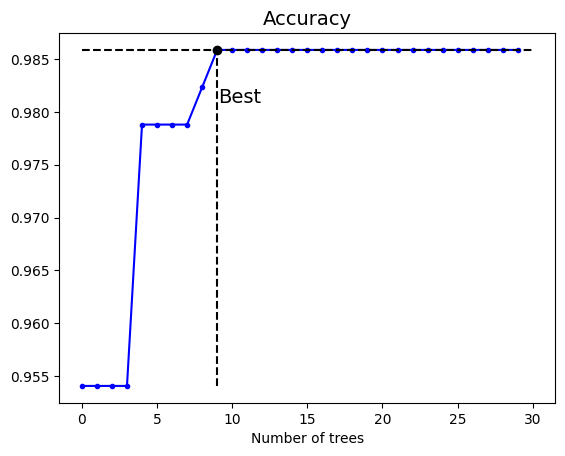

In [31]:
worst_score = np.min(scores)
best_score = np.max(scores)

plt.plot(scores, "b.-")
plt.plot([0, 30], [best_score, best_score], "k--")
plt.plot(bst_n_estimators, best_score, "ko")
plt.plot([bst_n_estimators, bst_n_estimators], [worst_score, best_score], "k--")
plt.text(bst_n_estimators+1.5, best_score-0.005, "Best", ha="center", fontsize=14)
plt.xlabel("Number of trees")
plt.title("Accuracy", fontsize=14)

plt.show()

Rather than training a large number of trees then looking back to find the best number you can use *warm_start=True* to keep using the existing trees when fit is called allowing incremental training<sup>1</sup>.

We can also use a *subsample* hyperparameter to specify the fraction of training instances used for each tree (Stochastic Gradient Boosting). This trades a higher bias for lower variance and speeds up training.

---
1. Geron2017

In [32]:
gbrt = GradientBoostingClassifier(max_depth=2, warm_start=True, subsample = 0.5, random_state=RANDOM_STATE)

max_val_score = float(0)
score_not_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_score = accuracy_score(y_val, y_pred)
    if val_score > max_val_score:
        max_val_score = val_score
        score_not_going_up = 0
    else:
        score_not_going_up += 1
        if score_not_going_up == 5:
            break  # early stopping

print("Number of estimators:", gbrt.n_estimators)
print("Maximum Accuracy:", max_val_score)

Number of estimators: 10
Maximum Accuracy: 0.9858657243816255


### XgBoost

Two very effective, efficient, and parallelizable algorithms, that are popular at time of writing are XGBoost<sup>2</sup> and lightGBM<sup>3</sup>. Both algorithms improve upon basic gradient boosted decision tree (GBDT) algorithms in a number of ways.

Both algorithms...
- ...can grow trees leaf-wise, so that each split is in the leaf that reduces the most loss, rather than a level-wise strategy, which maintains a more balanced tree with splits generally increasing as the levels increase. Although leaf-wise training is more prone to overfitting, it is more flexible and applicable to large datasets.
- ...allow for methods for finding the best split of features for each leaf, such as histogram-based bin sampling and ignoring sparse inputs. Histogram-based methods subsample the number of splits evaluated by a model by grouping features into a set of bins before building each tree.

For specifics look into https://xgboost.readthedocs.io/en/latest/tutorials/model.html

As can be seen it has a similar/better performance to adaboost but is much faster to compute

**TODO**
- improve this and the LGBM sections as these are really good models. Until I have written this up look at the following links below for more info:
  - https://medium.com/@am.sharma/lgbm-on-colab-with-gpu-c1c09e83f2af
  - https://devblogs.nvidia.com/gradient-boosting-decision-trees-xgboost-cuda/
  - http://mlexplained.com/2018/01/05/lightgbm-and-xgboost-explained/
  - https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
  - https://www.kaggle.com/stuarthallows/using-xgboost-with-scikit-learn
  - https://www.datacamp.com/community/tutorials/xgboost-in-python
    
---
1. https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
2. Chen2016
3. Ke2017

In [33]:
from xgboost import XGBClassifier

%timeit XGBClassifier(n_estimators =10, random_state=RANDOM_STATE).fit(X_train, y_train)

1.54 s ± 635 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%timeit AdaBoostClassifier(n_estimators =10, random_state=RANDOM_STATE).fit(X_train, y_train)

4.87 s ± 529 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%timeit GradientBoostingClassifier(n_estimators =10, random_state=RANDOM_STATE).fit(X_train, y_train)

12.3 s ± 894 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
XGmodel = XGBClassifier(max_depth = 3,
                        learning_rate = 0.1,
                        n_estimators=500,
                        booster = 'gbtree',
                        n_jobs =-1,
                        random_state=RANDOM_STATE)

XGmodel.fit(X_train, y_train)

y_pred = XGmodel.predict(X_val)

display(pd.DataFrame(classification_report(y_val, y_pred , output_dict = True)))

,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.928571,0.996466,0.964286,0.996719
recall,0.996296,1.000000,0.996466,0.998148,0.996466
f1-score,0.998145,0.962963,0.996466,0.980554,0.996529
support,270.000000,13.000000,0.996466,283.000000,283.000000


### LightGBM

LightGBM provides additional methods than XGBoost for finding the best split of features for each leaf include data subsampling and exclusive feature bundling.

Gradient-based one-side sampling, available in lightGBM, concentrates on data points with larger gradients rather than data points that contribute less to training. In order to ensure ignoring small gradients does not lead to biased sampling, data with small gradients are randomly sampled and these samples are given increased weight when assessing their contribution to the change in loss.

**TODO**
- add about the GPU enabled versions

**NOTE**
- `neg_bagging_fraction` is not available in Gradient-based one-side sampling

https://lightgbm.readthedocs.io/en/latest/index.html

In [37]:
from lightgbm import LGBMClassifier

%timeit LGBMClassifier(n_estimators =10, random_state=RANDOM_STATE).fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 131, number of negative: 2412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216240
[LightGBM] [Info] Number of data points in the train set: 2543, number of used features: 848
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.051514 -> initscore=-2.913014
[LightGBM] [Info] Start training from score -2.913014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 131, number of nega

In [38]:
LGBM_model = LGBMClassifier(boosting_type='gbdt',
                            max_depth=3,
                            n_estimators=500,
                            random_state=RANDOM_STATE,
                            neg_bagging_fraction = 0.5, # for subsampling interictal data
                            n_jobs =-1,
                            bagging_seed = RANDOM_STATE)

LGBM_model.fit(X_train, y_train)

y_pred = LGBM_model.predict(X_val)

display(pd.DataFrame(classification_report(y_val, y_pred , output_dict = True)))

[LightGBM] [Info] Number of positive: 131, number of negative: 2412
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216240
[LightGBM] [Info] Number of data points in the train set: 2543, number of used features: 848
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.051514 -> initscore=-2.913014
[LightGBM] [Info] Start training from score -2.913014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

,0,1,accuracy,macro avg,weighted avg
precision,1.000000,0.928571,0.996466,0.964286,0.996719
recall,0.996296,1.000000,0.996466,0.998148,0.996466
f1-score,0.998145,0.962963,0.996466,0.980554,0.996529
support,270.000000,13.000000,0.996466,283.000000,283.000000


Another package of note is CatBoost<sup>1,2</sup>, which makes improvements on the handling of categorical features and has been shown to be quicker on some datasets than XGBoost and LightGBM. However, although in both industrial and academic applications gradient boosted trees are becoming known as consistently strong performing classifiers, the interpretability of final model is still worse than more basic models such as decision trees.

---
1. Dorogush2018
2. Prokhorenkova2018

# Exercises

Below are a few suggested exercises that may help improve your skills.

1. compare boosting and pasting models

2. Weight classifiers in terms of importance. Weight the best to worst classifiers based on other notebooks outcomes to see if this improves performance. This can be done in the VotingClassifier using a variable called 'weight' followed by a list of the wieghtng order (e.g. [1,2,3])

3. load machine learning instances from previous notebooks and put them into a voting classifier

4. look for optimal hyperparameters using optimisation techniques

5. test models on all patients in a patient specific manner (patient independent is tricky because all the channels are different for each patient)

# Extra

## Plot Missclassified

Lets have a look at the samples that were missclasified. You will need the full data downloaded for this to work (rather than just the feature df), so because that takes a while I've made this an extra part.

**TODO**
- get this code working again

In [41]:
import mne
from scipy.io import loadmat
import glob
from sklearn.ensemble import RandomForestClassifier


def mat_to_mne(file_path):
    mat = loadmat(file_path)  # load mat-file

    data = mat['data']  # variable in mat file
    channels = mat['channels']  # dtypes of structures are "unsized objects"
    freq = mat['freq'][0]

    channels_list = []
    for channel_array in channels[0][0]:
        channels_list.append(channel_array[0])

    df = pd.DataFrame(data,
                      index=channels_list)

    df = df.T

    info = mne.create_info(ch_names=list(df.columns),
                               sfreq=freq,
                               ch_types=['eeg']*df.shape[-1])

    df = df.apply(lambda x: x*1e-6) # data needs to be in volts rather than in microvolts (which it currently is)
    # transpose the data
    data_T = df.transpose()
    # create raw mne object
    raw = mne.io.RawArray(data_T, info)

    return raw


def plot_missclassified(predicted, y_test, test_index_list, file_list, plot_kwargs):

    for index, class_no in enumerate(predicted):
        if class_no != y_test[index]:
            file_path = file_list[test_index_list[index]]

            raw = mat_to_mne(file_path)

            raw.plot(**plot_kwargs)


plot_kwargs = {
    #'scalings': dict(eeg=20e-5),   # zooms the plot out
    'highpass': 0.5,              # filters out low frequencies
    'lowpass': 40.,                # filters out high frequencies
    }

index_train, index_test = train_test_split(list(range(0,len(reduced_features))), test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Assuming 'forest' is your trained RandomForestClassifier model from previous cells
forest = RandomForestClassifier(criterion='gini',
                                n_estimators=1000,
                                max_features = 'sqrt',
                                class_weight = 'balanced',
                                random_state=RANDOM_STATE,
                                n_jobs=-1)
forest.fit(X_train, y_train)
forest_predicted = forest.predict(X_test)

# Assuming the data files are in a directory named 'data' in the same directory as the notebook
# You might need to adjust the path based on where your data files are located
all_file_list = glob.glob('./*.mat')
# Filter the file list to include only files corresponding to the reduced features
file_list = [all_file_list[i] for i in reduced_features.index.values if i < len(all_file_list)]


plot_missclassified(forest_predicted, y_test, index_test, file_list, plot_kwargs)

IndexError: list index out of range

# License

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.